In [1]:
#default_exp tuning

# Tuning

<br>

### Imports

In [30]:
#exports
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GroupKFold

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, charge, utils

In [3]:
import FEAutils as hlp
import matplotlib.pyplot as plt

<br>

### User Inputs

In [4]:
intermediate_data_dir = '../data/intermediate'

<br>

### Preparing Data

First we'll load in the target and feature data for both the charging and discharging models

In [5]:
charge_x, charge_y = charge.prepare_training_input_data(intermediate_data_dir)
discharge_x, discharge_y = discharge.prepare_training_input_data(intermediate_data_dir)

charge_x.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,solar_7d_lag,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,weekend,hour,doy,dow
2017-11-10 05:00:00+00:00,12.190,12.07,11.880,11.29,13.37,13.43,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,5.0,314,4
2017-11-10 05:30:00+00:00,12.145,12.13,11.745,11.20,13.44,13.52,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,5.5,314,4
2017-11-10 06:00:00+00:00,12.100,12.19,11.610,11.11,13.51,13.61,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0,6.0,314,4
2017-11-10 06:30:00+00:00,11.985,12.05,11.315,10.85,13.52,13.62,0.00,0.48,0.55,0.52,0.915,0.575,0.66,0,6.5,314,4
2017-11-10 07:00:00+00:00,11.870,11.91,11.020,10.59,13.53,13.63,0.02,0.96,1.10,1.04,1.830,1.150,1.32,0,7.0,314,4


In [6]:
s_demand = clean.load_training_dataset(intermediate_data_dir, 'demand')['demand_MW']

s_demand.head()

datetime
2017-11-03 00:00:00+00:00    2.19
2017-11-03 00:30:00+00:00    2.14
2017-11-03 01:00:00+00:00    2.01
2017-11-03 01:30:00+00:00    1.87
2017-11-03 02:00:00+00:00    1.86
Freq: 30T, Name: demand_MW, dtype: float64

In [7]:
s_pv = clean.load_training_dataset(intermediate_data_dir, 'pv')['pv_power_mw']

s_pv.head()

datetime
2017-11-03 00:00:00+00:00    0.0
2017-11-03 00:30:00+00:00    0.0
2017-11-03 01:00:00+00:00    0.0
2017-11-03 01:30:00+00:00    0.0
2017-11-03 02:00:00+00:00    0.0
Freq: 30T, Name: pv_power_mw, dtype: float64

In [8]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2018-09-15'

charge_x_train, charge_x_test = get_train_test(charge_x, start_of_test_period)
charge_y_train, charge_y_test = get_train_test(charge_y, start_of_test_period)
discharge_x_train, discharge_x_test = get_train_test(discharge_x, start_of_test_period)
discharge_y_train, discharge_y_test = get_train_test(discharge_y, start_of_test_period)

<br>

### Evaluation Metrics

We want to evaluate each of our models based on their contribution to the final scoring value, to do this we'll first create some predictions for our discharge model.

<AxesSubplot:>

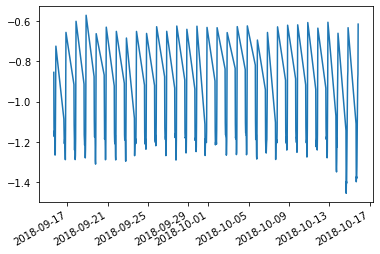

In [9]:
discharge_rf = RandomForestRegressor()

discharge_rf.fit(discharge_x_train, discharge_y_train)
discharge_y_pred = pd.Series(discharge_rf.predict(discharge_x_test), index=discharge_x_test.index)

discharge_y_pred.plot()

<br>

We'll then create a time-series of the percentage peak reduction for each day

In [10]:
#exports
def calculate_pct_peak_reduction_s(discharge_y_pred, s_demand):
    s_demand_test = s_demand.loc[discharge_y_pred.index]

    s_old_peaks = s_demand_test.groupby(s_demand_test.index.date).max()
    s_new_peaks = (s_demand_test+discharge_y_pred).groupby(s_demand_test.index.date).max()

    s_pct_peak_reduction = 100*(s_old_peaks - s_new_peaks)/s_new_peaks
    s_pct_peak_reduction.index = pd.to_datetime(s_pct_peak_reduction.index)

    return s_pct_peak_reduction

The average peak reduction was 45.48%


<AxesSubplot:>

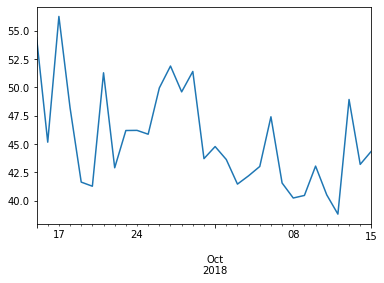

In [11]:
s_pct_peak_reduction = calculate_pct_peak_reduction_s(discharge_y_pred, s_demand)

print(f'The average peak reduction was {s_pct_peak_reduction.mean():.2f}%')

s_pct_peak_reduction.plot()

<br>

We'll then repeat this with the charging model

<AxesSubplot:>

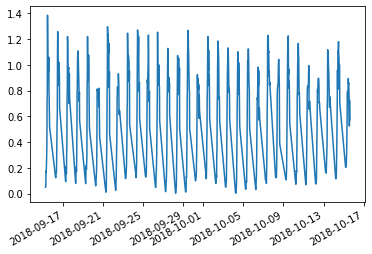

In [12]:
charge_rf = RandomForestRegressor()

charge_rf.fit(charge_x_train, charge_y_train)
charge_y_pred = pd.Series(charge_rf.predict(charge_x_test), index=charge_x_test.index)

charge_y_pred.plot()

<br>

For which we'll calculate the emissions factor series

In [13]:
#exports
def calculate_emissions_factor_s(charge_y_pred, s_pv, solar_factor=3, grid_factor=1):
    s_solar_charge_pct = (charge_y_pred - s_pv.loc[charge_y_pred.index]).clip(0).groupby(charge_y_pred.index.date).sum()/charge_y_pred.groupby(charge_y_pred.index.date).sum()
    s_grid_charge_pct = 1 - s_solar_charge_pct

    s_emissions_factor = solar_factor*s_solar_charge_pct + grid_factor*s_grid_charge_pct
    s_emissions_factor.index = pd.to_datetime(s_emissions_factor.index)

    return s_emissions_factor

<AxesSubplot:>

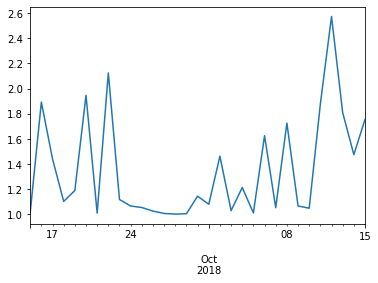

In [14]:
s_emissions_factor = calculate_emissions_factor_s(charge_y_pred, s_pv)

s_emissions_factor.plot()

<br>

We can then combine these two steps to determine our final score for each day

In [15]:
#exportd
def calculate_score_s(discharge_y_pred, charge_y_pred, s_demand, s_pv, solar_factor=3, grid_factor=1):
    s_pct_peak_reduction = calculate_pct_peak_reduction_s(discharge_y_pred, s_demand)
    s_emissions_factor = calculate_emissions_factor_s(charge_y_pred, s_pv, solar_factor=solar_factor, grid_factor=grid_factor)
    
    s_score = s_pct_peak_reduction*s_emissions_factor
    
    return s_score

The average score was: 60.86


<AxesSubplot:>

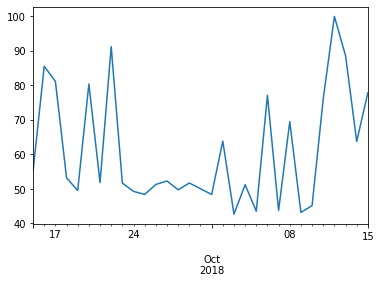

In [16]:
s_score = calculate_score_s(discharge_y_pred, charge_y_pred, s_demand, s_pv)

print(f'The average score was: {s_score.mean():.2f}')

s_score.plot()

<br>

For the charging we can also look at how much was sourced from PV relative to the potential maximum (capped at 6 MWh per day).

<AxesSubplot:>

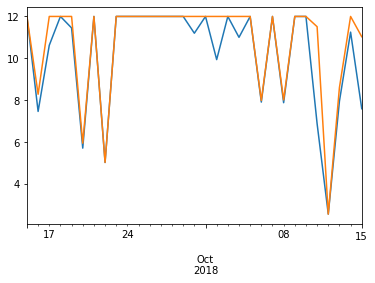

In [17]:
solar_charge = np.minimum(charge_y_pred, s_pv.loc[charge_y_pred.index])
day_solar_charge = solar_charge.groupby(solar_charge.index.date).sum().clip(0,12)
day_solar_charge.index = pd.to_datetime(day_solar_charge.index)

solar_potential = np.clip(s_pv.loc[charge_y_pred.index], 0, 2.5)
day_solar_potential = solar_potential.groupby(solar_potential.index.date).sum().clip(0,12)
day_solar_potential.index = pd.to_datetime(day_solar_potential.index)

day_solar_charge.plot()
day_solar_potential.plot()

Text(0, 0.5, '% exploited')

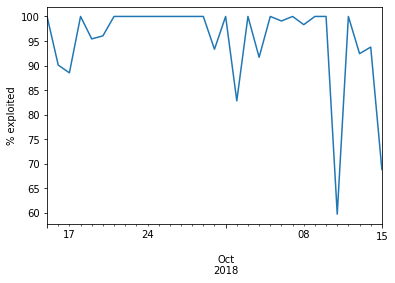

In [18]:
pct_exploit = 100 * day_solar_charge/day_solar_potential
pct_exploit.plot()
plt.ylabel('% exploited')

<br>

### Discharge Model Tuning

We'll begin by carrying out some feature selection

In [19]:
# use mlxtend to select the relevant features

In [24]:
discharge_x_train.head(3)

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,spatial_avg_temp,daily_avg_temp,SP_demand_7d_lag,evening_demand_avg_7d_lag,evening_demand_max_7d_lag,weekend,hour,doy,dow
2017-11-10 15:30:00+00:00,10.985,10.99,9.845,9.68,12.945,13.025,11.245000,11.449115,3.06,3.928333,4.59,0,15.5,314,4
2017-11-10 16:00:00+00:00,10.720,10.67,9.520,9.05,12.860,12.920,10.956667,11.449115,3.36,3.928333,4.59,0,16.0,314,4
2017-11-10 16:30:00+00:00,10.515,10.30,9.175,8.25,12.765,12.800,10.634167,11.449115,3.89,3.928333,4.59,0,16.5,314,4


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

peak_reduction_scorer = discharge.construct_peak_reduction_calculator(s_demand=s_demand, scorer=True)

sfs = SFS(
    RandomForestRegressor(),
    k_features=5, 
    n_jobs=-1,
    scoring=peak_reduction_scorer,
    verbose=2
)

week_groups = discharge_x_train.index.year + discharge_x_train.index.isocalendar().week/52
sfs.fit(discharge_x_train, discharge_y_train, groups=week_groups)

sfs.k_feature_names_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


<br>

We'll now do some hyper-parameter tuning using the `skopt` library

In [21]:
# Look at plotting callback - https://github.com/scikit-optimize/scikit-optimize/issues/576#issuecomment-507395129

pipeline = Pipeline([
    ('pandas_RF', utils.PandasRandomForestRegressor())
])

search_spaces = {
        'pandas_RF__min_samples_leaf': Integer(1, 20, 'uniform'),
        'pandas_RF__criterion': Categorical(['mse', 'mae']),
        'pandas_RF__n_estimators': Integer(50, 250, 'uniform'),
        'pandas_RF__max_features': Categorical(['auto', 'sqrt']),
        'pandas_RF__max_depth': Integer(10, 50, 'uniform'),
        'pandas_RF__min_samples_split': Integer(2, 10, 'uniform'),
        'pandas_RF__min_samples_leaf': Integer(1, 4, 'uniform'),
        'pandas_RF__bootstrap': Categorical([True, False])
}

opt = utils.BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=5,
    verbose=1,
    cv=8, # 8 works well for me as that's how many concurrent workers I can use
    scoring=peak_reduction_scorer,
    n_jobs=-1
)

fit_BayesSearchCV = True

if fit_BayesSearchCV == True:
    opt.fit(discharge_x_train, discharge_y_train, groups=week_groups)

    print(f'\nCross-validation score: {opt.best_score_:.2f}')
    print(f'Hold-out score: {opt.score(discharge_x_test, discharge_y_test):.2f}')
    print(f'\nBest params: \n{opt.best_params_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   21.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  3.4min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   47.6s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   50.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    8.3s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   49.8s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   55.5s finished



Cross-validation score: 91.86
Hold-out score: 80.17

Best params: 
OrderedDict([('pandas_RF__bootstrap', True), ('pandas_RF__criterion', 'mae'), ('pandas_RF__max_depth', 22), ('pandas_RF__max_features', 'sqrt'), ('pandas_RF__min_samples_leaf', 1), ('pandas_RF__min_samples_split', 7), ('pandas_RF__n_estimators', 223)])


In [22]:
# Cross-validation score: 91.20
# Hold-out score: 80.95

<br>

Finally we'll export the relevant code to our `batopt` module

In [23]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-cleaning.ipynb.
Converted 02-discharging.ipynb.
Converted 03-charging.ipynb.
Converted 04-constraints.ipynb.
Converted 05-tuning.ipynb.
Converted 06-pipeline.ipynb.
Converted 07-charging-nn.ipynb.
Converted 08-similar-days.ipynb.
